
### NFL Score Prediction Model using Historical Box Score Data
##### Eddie McGolrick
##### Fall 2020

###### **1. What is your project topic?  Briefly summarize what you’re trying to accomplish**
###### For this project, the sportsreference API was used to obtain historical NFL box score data from 1990 to 2018. The overall goal is to use this data to predict the scoring margin between the Home and Away team from each game (i.e., the 'spread'). 

###### **2. What were the “results” of your work?**
###### After obtaining the data from the API and performing preprocessing on the data, such as adding new metrics, removing null values, and changing metrics into a digestible format, such as changing time of posession to simply total seconds of posession, I designed a linear regression model for predicting the spread. Using an approximately 80/20 train-test split, the model uses 37 predictive variables to estimate the spread. The model has an R-squared of 0.9097 and an RMSE of 4.8.


###### **3. What would the next logical step be in this exploration?**
###### There are a few next steps that would be logical in this analysis. First, some Lasso should be done to reduce potential overfitting, as some of these 37 predictors may have high collinearity. Second, it is necessary to decide how this should be extrapolated to predicting future games. Currently, even on the test set, it is using the _known_ statistics from the game to predict what the score was. For future games, we need a way to estimate what those metrics _might be_, and feed this into the model. Possible methods for this: Use a team's average rush yards, 3rd down %, etc., on the current season, on their previous 16 gamesd played, or design some sort of moving averages process that predicts what these stats will be for the game. Another way to add another layer of predictability would be to multiply these numbers by a factor based on the quality of defenses. So, if a team is playing the Steelers, they may be predicted to have much less yards than against the Jets.

###### **4. What did you find difficult to do during the project?**
###### Once I had built the simple linear regression, I began tinkering with the idea of using Lasso / cross-validation to select the most important variables and improve accuracy / reduce overfitting. This proved more difficult than I thought it would be, as changing the alpha value and other parameters did not seem to imnprove the model drastically. Another difficiult aspect, as mentioned above, is figuring out the best way to guess future box score statistics to get a spred before the game is played.

###### **5. What topic did you wish you were more knowledgeable about/what would have been handy to know while you were doing the project?**
###### I wish that I could have figured out a faster way to obtain the data. The sportsreference API was very in-depth and useful, but it took a number of hours just to get data from 1990-2018, an ~7000-column dataset. I want to spend more time exploring the foundations and more advanced concepts of web scraping, data mining, etc.


In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

df1 = pd.read_csv(r'C:\Users\jemcg\OneDrive\Desktop\Grad School\Classes\Fall 2020\Sports\nfl_historical_data_columns_added_upto_2012.csv')
df2 = pd.read_csv(r'C:\Users\jemcg\OneDrive\Desktop\Grad School\Classes\Fall 2020\Sports\2012ON_nfl_historical_data.csv')

df2.columns = df1.columns
df = pd.concat([df1,df2], ignore_index=True)

df.date = pd.to_datetime(df.date)

df_sept = df[(pd.DatetimeIndex(df.date).year==2012) & (pd.DatetimeIndex(df.date).month==9)]

real_sept12 = df_sept[~df_sept.duplicated(subset=['winning_name', 'losing_name'])]

df = df[~((pd.DatetimeIndex(df.date).year==2012) & (pd.DatetimeIndex(df.date).month==9))]

df = pd.concat([df, real_sept12]).sort_values(by=['date'],ignore_index=True)

df['tot_pass_yards'] = df['away_pass_yards'] + df['home_pass_yards']

df['away_yards_prush'] = (df['away_rush_yards'] / df['away_rush_attempts'])
df['home_yards_prush'] = (df['home_rush_yards'] / df['home_rush_attempts'])

df['away_compl_pct'] = (df['away_pass_completions'] / df['away_pass_attempts'])
df['home_compl_pct'] = (df['home_pass_completions'] / df['home_pass_attempts'])

df['away_yards_p_attempt'] = (df['away_pass_yards'] / df['away_pass_attempts'])
df['home_yards_p_attempt'] = (df['home_pass_yards'] / df['home_pass_attempts'])

df['away_third_pct'] = (df['away_third_down_conversions'] / df['away_third_down_attempts'])
df['home_third_pct'] = (df['home_third_down_conversions'] / df['home_third_down_attempts'])

df['away_fourth_pct'] = (df['away_fourth_down_conversions'] / df['away_fourth_down_attempts'])
df['home_fourth_pct'] = (df['home_fourth_down_conversions'] / df['home_fourth_down_attempts'])


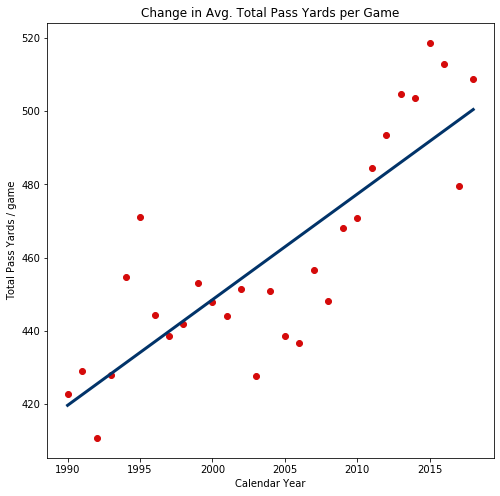

In [2]:
df_tot_pass = df.groupby(by=[pd.DatetimeIndex(df['date']).year])['tot_pass_yards'].mean()
yrs = np.arange(1990,2019)

totp = np.array(df_tot_pass)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

plt.scatter(yrs, totp, color='#D50A0A')
plt.plot(np.unique(yrs), np.poly1d(np.polyfit(yrs, totp, 1))(np.unique(yrs)), color='#013369', lw=3)
plt.ylabel("Total Pass Yards / game")
plt.xlabel("Calendar Year")
plt.title("Change in Avg. Total Pass Yards per Game")

plt.show()

fig.savefig(r'C:\Users\jemcg\OneDrive\Desktop\Grad School\Classes\Fall 2020\Sports\total_pass.png')

##### As we can see, the average total pass yards per game has generally risen since 1990. This narrative is pretty accepted in the NFL community — passing has become a larger and larger part of many teams' gameplans while running backs have even been deemed 'obsolete' or 'interchangeable' once you get past the elite tier. <br><br>Does this mean that teams derive a higher portion of their overall yards from passing these days?

In [3]:
# fig = plt.figure(figsize=(8,8))
# ax = fig.add_subplot(1,1,1)

# plt.scatter(yrs, totp, color='#D50A0A')
# plt.ylabel("Total Pass Yards / game")
# plt.xlabel("Calendar Year")
# plt.title("Change in Avg. Total Pass Yards per Game")

# plt.show()

# fig.savefig(r'C:\Users\jemcg\OneDrive\Desktop\Grad School\Classes\Fall 2020\Sports\total_pass_noline.png')

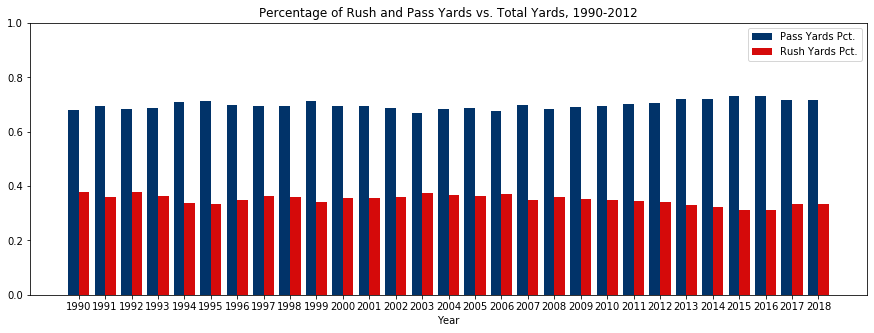

In [4]:
df_cols_nonan = df[df.columns[~df.isnull().any()]]
cols_nonan = []

    
df_cols_nonan['total_yards'] = df_cols_nonan['away_total_yards']+df_cols_nonan['home_total_yards']
df_cols_nonan['total_rush_yards'] = df_cols_nonan['away_rush_yards']+df_cols_nonan['home_rush_yards']
df_cols_nonan['total_pass_yards'] = df_cols_nonan['away_pass_yards']+df_cols_nonan['home_pass_yards']
df_cols_nonan

for col in df_cols_nonan:
    cols_nonan.append(col)
    
df_cols_nonan['date'] = pd.to_datetime(df_cols_nonan['date'])

df_cols_nonan['rush_yards_pct'] = df_cols_nonan['total_rush_yards'] / df_cols_nonan['total_yards']
df_cols_nonan['pass_yards_pct'] = df_cols_nonan['total_pass_yards']/df_cols_nonan['total_yards']

df_cols_nonan['year'] = df_cols_nonan['date'].apply(lambda x: x.year)
df_cols_nonan['month'] = df_cols_nonan['date'].apply(lambda x: x.month)

df_gb = pd.DataFrame(df_cols_nonan.groupby(['year', 'month'])[['pass_yards_pct', 'rush_yards_pct']].mean()).reset_index()


df_gb['combined']=df_gb.apply(lambda x:'%i-%i' % (x['month'],x['year']),axis=1)
df_gb['combined'] = pd.to_datetime(df_gb['combined'])
df_gb_yr = pd.DataFrame(df_cols_nonan.groupby(['year'])[['pass_yards_pct', 'rush_yards_pct']].mean()).reset_index()



clrs = ['#013369', '#D50A0A']

fig = plt.figure(figsize = [15,5])
ax = fig.add_subplot(1,1,1)

def subcategorybar(X, vals, width=0.8):
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge", color=clrs[i]) 
    plt.xticks(_X, X)
    
subcategorybar(df_gb_yr['year'], [df_gb_yr['pass_yards_pct'], df_gb_yr['rush_yards_pct']])
plt.title('Percentage of Rush and Pass Yards vs. Total Yards, 1990-2012')
plt.xlabel('Year')
plt.ylim(0,1)
plt.legend(['Pass Yards Pct.', 'Rush Yards Pct.'])
plt.show()

fig.savefig(r'C:\Users\jemcg\OneDrive\Desktop\Grad School\Classes\Fall 2020\Sports\yards_proportion.png')

##### Interestingly, the percentage of passing vs. rushing yards out of total offense seems to have remained relatively constant over the last three decades. <br><br>Since passing yards are on the rise, this chart implies that overall offense (and not just passing yards) is increasing.

In [5]:
df.drop(columns=['duration'], inplace=True)


In [6]:

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)




In [7]:
l = ['stadium', 'attendance', 'winner', 'away_points', 'away_first_downs', 'away_rush_yards', 'away_yards_prush', 'away_rush_touchdowns',
     'away_compl_pct', 'away_pass_yards', 'away_yards_p_attempt', 'away_pass_touchdowns', 'away_interceptions', 'away_times_sacked', 
     'away_total_yards', 'away_fumbles', 'away_fumbles_lost', 'away_turnovers', 'away_penalties', 'away_yards_from_penalties',
     'away_time_of_possession', 'away_third_pct', 'away_fourth_pct', 'home_points', 'home_first_downs', 'home_rush_yards', 'home_yards_prush', 
     'home_rush_touchdowns', 'home_compl_pct', 'home_pass_yards', 'home_yards_p_attempt', 'home_pass_touchdowns', 'home_interceptions', 
     'home_times_sacked', 'home_total_yards', 'home_fumbles', 'home_fumbles_lost', 'home_turnovers', 'home_penalties', 
     'home_yards_from_penalties', 'home_time_of_possession', 'home_third_pct', 'home_fourth_pct']



In [8]:
df_trim = df[l]

def time_possession(top):
    mins = top.str[:2]
    secs = top.str[-2:]
    total_s = mins.astype(int)*60+secs.astype(int)
    return total_s

top=df_trim['home_time_of_possession']
df_trim['home_time_of_possession'] = time_possession(top)

top=df_trim['away_time_of_possession']
df_trim['away_time_of_possession'] = time_possession(top)

In [9]:
dep_vars = ['attendance', 'away_first_downs', 'away_rush_yards', 'away_yards_prush', 'away_rush_touchdowns',
     'away_compl_pct', 'away_pass_yards', 'away_yards_p_attempt', 'away_pass_touchdowns', 'away_interceptions', 'away_times_sacked', 
     'away_fumbles', 'away_fumbles_lost', 'away_turnovers', 'away_penalties', 'away_yards_from_penalties',
     'away_time_of_possession', 'away_third_pct', 'away_fourth_pct', 'home_first_downs', 'home_rush_yards', 'home_yards_prush', 
     'home_rush_touchdowns', 'home_compl_pct', 'home_pass_yards', 'home_yards_p_attempt', 'home_pass_touchdowns', 'home_interceptions', 
     'home_times_sacked', 'home_fumbles', 'home_fumbles_lost', 'home_turnovers', 'home_penalties', 
     'home_yards_from_penalties', 'home_time_of_possession', 'home_third_pct', 'home_fourth_pct']


X = np.array(df_trim[dep_vars])

df_trim['pt_spread'] = df_trim['home_points'] - df_trim['away_points']

y = np.array(df_trim['pt_spread']).reshape(-1,1)

split_fact = 1700
X.shape
X_train = X[:split_fact,:]
X_test = X[split_fact:,:]

y_train = y[:split_fact]
y_test = y[split_fact:]

In [10]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

lm = LinearRegression().fit(X_train, y_train)

y_pred = lm.predict(X_test)
print('Summary Statistics of Simple Linear Regression Model:\n')
# The coefficients
print('Coefficients: \n\n', lm.coef_)
# The mean squared error
print('\nMean squared error (MSE): %.2f'
      % mean_squared_error(y_test, y_pred))
print('Root mean squared error (RMSE): %.2f'
      % np.sqrt(mean_squared_error(y_test, y_pred)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.5f'
      % r2_score(y_test, y_pred))

Summary Statistics of Simple Linear Regression Model:

Coefficients: 

 [[ 3.77930315e-07 -3.08562649e-01 -3.82231415e-02  3.79944071e-01
  -2.95252140e+00 -5.98542561e+00  1.05585925e-03 -8.20355250e-01
  -3.26124888e+00  8.58287736e-01  5.07137098e-01  3.90781822e-02
   5.98405290e-01  1.45669303e+00 -9.84613724e-02  4.63517298e-02
   2.68765338e-03 -8.00390790e+00 -2.00277394e+00  1.19156465e-01
   2.87657208e-02 -8.45075554e-02  3.61930598e+00  6.34048402e+00
   1.90646983e-03  5.98816421e-01  3.61091641e+00 -8.22582519e-01
  -6.40937518e-01 -2.13129579e-01 -6.34625189e-01 -1.45720771e+00
  -1.07088924e-01 -1.92811316e-02 -3.26965150e-03  5.27473482e+00
   1.90048516e+00]]

Mean squared error (MSE): 23.05
Root mean squared error (RMSE): 4.80
Coefficient of determination: 0.90965


In [11]:
pd.set_option('display.float_format', lambda x: '%.8f' % x)
print("Variable Names and Coefficients For Simple Linear Regression:\n")
lin_coefs = pd.DataFrame({
    'Variable':dep_vars,
    'Coef':pd.Series(lm.coef_.reshape(37,))
})

new_row = pd.DataFrame({
    'Variable':'intercept',
    'Coef': lm.intercept_
    
}, index =[0])

lin_coefs = pd.concat([new_row, lin_coefs]).reset_index(drop = True) 
lin_coefs = lin_coefs.set_index("Variable")
print(lin_coefs)

Variable Names and Coefficients For Simple Linear Regression:

                                 Coef
Variable                             
intercept                  5.93417083
attendance                 0.00000038
away_first_downs          -0.30856265
away_rush_yards           -0.03822314
away_yards_prush           0.37994407
away_rush_touchdowns      -2.95252140
away_compl_pct            -5.98542561
away_pass_yards            0.00105586
away_yards_p_attempt      -0.82035525
away_pass_touchdowns      -3.26124888
away_interceptions         0.85828774
away_times_sacked          0.50713710
away_fumbles               0.03907818
away_fumbles_lost          0.59840529
away_turnovers             1.45669303
away_penalties            -0.09846137
away_yards_from_penalties  0.04635173
away_time_of_possession    0.00268765
away_third_pct            -8.00390790
away_fourth_pct           -2.00277394
home_first_downs           0.11915647
home_rush_yards            0.02876572
home_yards_prush         

(0.0001, 0.31622776601683794)

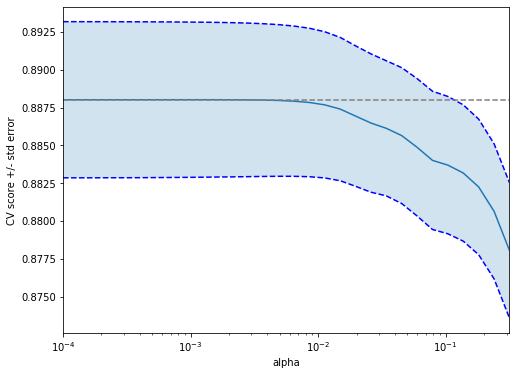

In [12]:
lasso = Lasso(random_state=0, max_iter=10000)
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(X_train, y_train)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)


# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

##### This is some intial analysis I did for possible alpha values in a Lasso model. This will be explored further.